# SVZ all cells statistical test (accounting for group structure)

## Outline

The **MLAging - SVZ all-cell** workflow consists of sections:

`30 SVZpreprocessing.R` Data preprocessing and preparation in Seurat.

`311 SVZ All-cell ELN Tuning - Before Binarization` ML model tunning using *non-binarized* HVGs and hyperparameter selection using `GridSearchCV`.

`312 SVZ All-cell ELN Tuning - After Binarization` ML model tunning using *binarized* HVGs and hyperparameter selection using `GridSearchCV`.

`321 SVZ All-cell ELN 10x` Run the best ELN model for both binarized and nonbinarized HVGs over 10 random seeds.

`322 SVZ All-cell MLP 10x - Before Binarization` Run the best MLP model for *non-binarized* HVGs over 10 random seeds.

`323 SVZ All-cell MLP 10x - After Binarization` Run the best MLP model for *binarized* HVGs over 10 random seeds.
 
`33 SVZ All-cell Model Result Viz` Result visulization.

`34 SVZ All-cell Stat` Stat test on whether exercise rejuvenates cells    -- **this notebook:** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from statistics import mean, stdev
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from src.data_processing import *
from src.grid_search import *

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf

In [2]:
input_train="../data/svz_processed/svz_ctl_train_cell_sep3integ_batch1.csv" 
input_test="../data/svz_processed/svz_ctl_test_cell_sep3integ_batch2.csv"
input_test_34="../data/svz_processed/svz_ex_test_34_cell_sep3integ_batch2.csv" 
input_test_68="../data/svz_processed/svz_ex_test_68_cell_sep3integ_batch2.csv"

df_train = pd.read_csv(input_train, index_col=0)
df_test = pd.read_csv(input_test, index_col=0)
df_test_34 = pd.read_csv(input_test_34, index_col=0)
df_test_68 = pd.read_csv(input_test_68, index_col=0)

In [3]:
file = open('../results/svz_int2/eln_model_test_models.save', 'rb')
model = pickle.load(file)[0]
file.close()

In [4]:
def violin_df(animal_list, data_df, model):
    df_vol = pd.DataFrame(columns=['animal', 'target', 'major_group', 'pred_prob'])
    for i in animal_list:
        print(i)
        idx = data_df.loc[data_df['animal'] == i,].index
        sub_df = data_df.loc[idx]
        df_new = sub_df.loc[:,['animal', 'target', 'major_group']]
    
        train_Xi = sub_df.iloc[:,:-3]
        train_Xi = binarize_data(train_Xi)
            
        test_y_pred = pd.DataFrame(model.predict_proba(train_Xi)[:,1], columns=['pred_prob'])
        test_y_pred.index = idx
        df_new['pred_prob'] = test_y_pred
        df_vol = pd.concat([df_vol, df_new])
    df_vol['pred_prob'] =  df_vol['pred_prob'].astype(float)
    return df_vol

In [5]:
import statsmodels.formula.api as smf
train_control_list = [ "Y5", "Y7", "O5","O7"]
test_ex_34_list = ['Y3', 'Y4', 'O3', 'O4', ]
test_ex_68_list = ['Y6', 'Y8', 'O6', 'O8']
test_control_list = ["Y1", "Y2", "O2"]

results = {}
train_vol = violin_df(train_control_list, df_train, model)
test_ex_34_vol = violin_df(test_ex_34_list, df_test_34, model)
test_ex_68_vol = violin_df(test_ex_68_list, df_test_68, model)
test_vol = violin_df(test_control_list, df_test, model)

test_vol["AgeCond"] = "Young Control"
test_vol.loc[test_vol.target == 1,'AgeCond'] = "Aged Control"
    
test_ex_34_vol["AgeCond"] = "Young Exercise"
test_ex_34_vol.loc[test_ex_34_vol.target == 1,'AgeCond'] = "Aged Exercise"
    
test_ex_68_vol["AgeCond"] = "Young Exercise"
test_ex_68_vol.loc[test_ex_68_vol.target == 1,'AgeCond'] = "Aged Exercise"
    
test_vol_all = pd.concat([test_vol, test_ex_34_vol, test_ex_68_vol])
test_ex_vol = pd.concat([test_ex_34_vol, test_ex_68_vol])
    
test_vol_young = test_vol_all.loc[test_vol_all.target==0,:]
test_vol_young["exercise"] = "Y"
test_vol_young.loc[test_vol_young.AgeCond == "Young Control",'exercise'] = "N"
model = smf.mixedlm('pred_prob ~ exercise', data=test_vol_young, groups=test_vol_young['animal'])
result_young_ex = model.fit()

test_vol_aged = test_vol_all.loc[test_vol_all.target==1,:]
test_vol_aged["exercise"] = "Y"
test_vol_aged.loc[test_vol_aged.AgeCond == "Aged Control",'exercise'] = "N"
model = smf.mixedlm('pred_prob ~ exercise', data=test_vol_aged, groups=test_vol_aged['animal'])
result_aged_ex = model.fit()

Y5
Y7
O5
O7
Y3
Y4
O3
O4
Y6
Y8
O6
O8
Y1
Y2
O2


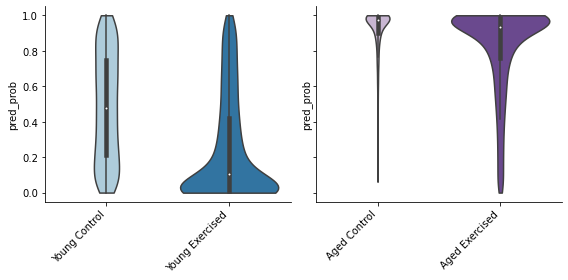

In [10]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), sharey=True)

# Plot for test_vol_young
sns.violinplot(x=test_vol_young.exercise, y=test_vol_young.pred_prob, data=test_vol_young, cut=0,
               scale='count', 
               bw=0.25,
               palette=[sns.color_palette("Paired")[0]]*1 + [sns.color_palette("Paired")[1]]*1,
               ax=axs[0])

axs[0].set_xticklabels(["Young Control", "Young Exercised"],
        rotation=45,
        horizontalalignment='right')
axs[0].set_xlabel("")
sns.despine(ax=axs[0])

# Plot for test_vol_aged
sns.violinplot(x=test_vol_aged.exercise, y=test_vol_aged.pred_prob, data=test_vol_aged, cut=0,
               scale='count', 
               bw=0.25,
               palette=[sns.color_palette("Paired")[8]]*1 + [sns.color_palette("Paired")[9]]*1,
               ax=axs[1])

axs[1].set_xticklabels(["Aged Control", "Aged Exercised"],
        rotation=45,
        horizontalalignment='right')
axs[1].set_xlabel("")
sns.despine(ax=axs[1])

fig.tight_layout()
plt.savefig('../figures/S8c_four_violin.pdf')
plt.show()

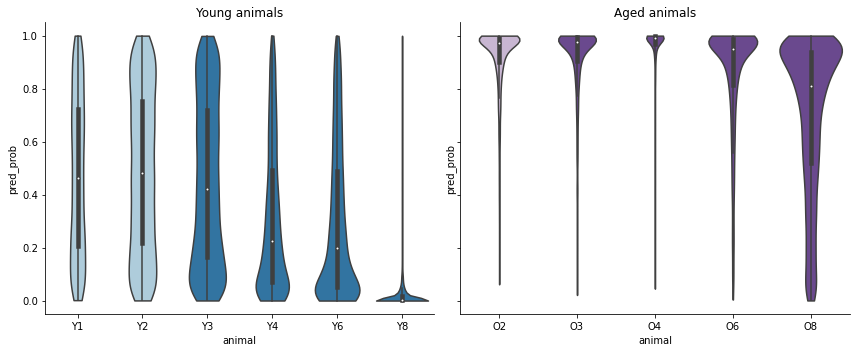

In [14]:
fig, axs = plt.subplots(1,2, figsize=(12, 5), sharey=True)

# Plot for test_vol_young
sns.violinplot(x=test_vol_young.animal, y=test_vol_young.pred_prob, data=test_vol_young, cut=0,
               scale='count', 
               palette=[sns.color_palette("Paired")[0]]*2 + [sns.color_palette("Paired")[1]]*4,
               ax=axs[0])

axs[0].set_title("Young animals")
sns.despine(ax=axs[0])

# Plot for test_vol_aged
sns.violinplot(x=test_vol_aged.animal, y=test_vol_aged.pred_prob, data=test_vol_aged, cut=0,
               scale='count',
               palette=[sns.color_palette("Paired")[8]]*1 + [sns.color_palette("Paired")[9]]*4,
               ax=axs[1])

axs[1].set_title("Aged animals")
sns.despine(ax=axs[1])
fig.tight_layout()
plt.savefig('../figures/S8c2d_11_violin.pdf')
plt.show()

In [19]:
import statsmodels.formula.api as smf

# Fit mixed-effects model
model = smf.mixedlm('pred_prob ~ exercise', data=test_vol_aged, groups=test_vol_aged['animal'])
result = model.fit()

# Print model summary
print(result.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: pred_prob
No. Observations:  21110   Method:             REML     
No. Groups:        5       Scale:              0.0428   
Min. group size:   1776    Log-Likelihood:     3287.5263
Max. group size:   6378    Converged:          Yes      
Mean group size:   4222.0                               
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.917    0.113  8.110 0.000  0.695  1.139
exercise[T.Y] -0.059    0.126 -0.469 0.639 -0.307  0.188
Group Var      0.013    0.049                           



In [20]:
import statsmodels.formula.api as smf

# Fit mixed-effects model
model = smf.mixedlm('pred_prob ~ exercise', data=test_vol_young, groups=test_vol_young['animal'])
result = model.fit()

# Print model summary
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pred_prob 
No. Observations: 30633   Method:             REML      
No. Groups:       6       Scale:              0.0640    
Min. group size:  2210    Log-Likelihood:     -1380.6524
Max. group size:  7603    Converged:          Yes       
Mean group size:  5105.5                                
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.480    0.110  4.351 0.000  0.264  0.697
exercise[T.Y] -0.213    0.135 -1.574 0.115 -0.478  0.052
Group Var      0.024    0.068                           

